# **Build a CNN from scratch and attempt to detect house numbers using the standard SVHN dataset**


**1. SVHN Dataset Overview [1]**\
\
The dataset has images of digits taken from different places of the street from house numbers in Google Street View images and are hosted by Stanford University. The images from the dataset are similar in philosophy with the MNIST dataset with 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.\
$73257$ digits for training, $26032$ digits for testing, and $531131$ additional, somewhat less difficult samples, to use as extra training data. \
\
The dataset comes in two formats:


1.   Original images with character level bounding boxes.
2.   MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).\
\
For the implementation of the code, I have used second form of dataset. The MNIST like dataset of the SVHN has cropped images of the digits with three files as:
\begin{align}
 \text{train_32x32.mat}\\
 \text{test_32x32.mat}\\
\text{extra_32x32.mat}\\
\end{align}





# **Let's start with pre-processing**

The data of the SVHN dataset comes originally in .mat file format. The .mat file format is best processed with MATLAB. To process the images in Python some preprocessing is required. \

The code is implemented in Google Colab

**1. Importing important libraries**

In [35]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

%matplotlib inline

**2. Data loading**

In [36]:
train_data = loadmat('/content/train_32x32.mat')
test_data = loadmat('/content/test_32x32.mat')

In [37]:
#checking the type of file loaded
print(type(train_data))
print(type(test_data))

#Checking the content in the file
print(train_data)
print(test_data)

<class 'dict'>
<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011', '__version__': '1.0', '__globals__': [], 'X': array([[[[ 33,  84,  19, ...,  92, 190, 216],
         [ 30,  76,  54, ...,  78, 188, 217],
         [ 38,  59, 110, ..., 101, 191, 212]],

        [[ 15,  86,  20, ...,  94, 205, 221],
         [ 23,  73,  52, ...,  82, 203, 222],
         [ 19,  66, 111, ..., 105, 206, 217]],

        [[ 15,  77,  25, ..., 114, 220, 226],
         [ 17,  78,  57, ..., 101, 218, 227],
         [ 19,  56, 116, ..., 125, 220, 221]],

        ...,

        [[ 72,  90,  65, ..., 200, 229, 200],
         [ 65,  78, 144, ..., 201, 231, 199],
         [ 56,  69, 223, ..., 203, 224, 191]],

        [[ 82,  88,  78, ..., 192, 229, 193],
         [ 77,  77, 148, ..., 193, 229, 188],
         [ 57,  67, 218, ..., 195, 224, 182]],

        [[ 89,  88,  98, ..., 190, 229, 197],
         [ 79,  78, 158, ..., 191, 228, 189],
         [ 59,  66, 22

from the train_data and test_data, I observed that there are two keys, \
**Input image data**: 'X' and **Label**: 'y'
\
\
Converting dictionary to numpy array

In [38]:
# Converting the dictionary data to numpy array 
train_X = np.array(train_data['X'])
test_X = np.array(test_data['X'])

train_y = train_data['y']
test_y = test_data['y']

In [39]:
#Shape of array
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


From the shape of the input images, it is clear that the images are color images.\
The shape of the input images are not in the order (None, d, m, n), Therefore, we need to reshape the shape of the image by changing the axis of the input images to train the model in proper sequence of the array.

In [40]:
train_X.shape

(32, 32, 3, 73257)

In [41]:
train_X = np.moveaxis(train_X, -1, 0)
test_X = np.moveaxis(test_X, -1, 0)
print(train_X.shape)
print(test_X.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


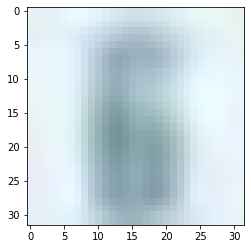

[6]


In [42]:
plt.imshow(train_X[1990])
plt.show()

print(train_y[1990])

In [43]:
# Convert train and test images into 'float64' type

train_X = train_X.astype('float64')
test_X = test_X.astype('float64')
# Convert train and test labels into 'int64' type

train_y = train_y.astype('int64')
test_y = test_y.astype('int64')

 **2. Data Normalizing**\
 Data normalization is used to change the numeric values in the images of the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different ranges. In case of images, we ensure that the range of the input images pixel values are in similar distribution (Gaussian distribution) **[3,4]**.

In [44]:
# Normalize the images data

train_X /= 255.0
test_X /= 255.0

In [46]:
print(train_X)
print(test_X)

[[[[0.12941176 0.11764706 0.14901961]
   [0.05882353 0.09019608 0.0745098 ]
   [0.05882353 0.06666667 0.0745098 ]
   ...
   [0.28235294 0.25490196 0.21960784]
   [0.32156863 0.30196078 0.22352941]
   [0.34901961 0.30980392 0.23137255]]

  [[0.10980392 0.15294118 0.1372549 ]
   [0.05490196 0.09803922 0.08627451]
   [0.05490196 0.07843137 0.06666667]
   ...
   [0.15686275 0.15294118 0.19607843]
   [0.2627451  0.22745098 0.20392157]
   [0.3254902  0.30588235 0.23529412]]

  [[0.15686275 0.16078431 0.14901961]
   [0.07058824 0.08235294 0.10196078]
   [0.0627451  0.06666667 0.09019608]
   ...
   [0.09019608 0.11372549 0.17647059]
   [0.1372549  0.16470588 0.17254902]
   [0.28235294 0.27058824 0.20784314]]

  ...

  [[0.3372549  0.31764706 0.29411765]
   [0.34117647 0.32156863 0.27843137]
   [0.32156863 0.30980392 0.25490196]
   ...
   [0.40784314 0.40784314 0.34117647]
   [0.40784314 0.41176471 0.31764706]
   [0.40392157 0.41176471 0.30588235]]

  [[0.32941176 0.3372549  0.25098039]
   [0.3

**One-hot encoding of train and test labels**

In [47]:
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.fit_transform(test_y)
print(train_y)
print(test_y)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**3. Split train data into train and validation sets**

In [48]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y,
                                                  test_size=0.2)
y_val.shape

(14652, 10)

# **Let's start implementation of CNN model**

**1. importing necessary libraries**

In [49]:
import os
import sys

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import Model


**2. CNN model with residual connections, dropout layers, and attention mechanism** \
**Residual Connections :** Residual
connections avoid the vanishing gradient problem in a
deep network. Residual connections are the tool to
enhance the learning process by boosting the information
flow in the deep net [5].

**Dropout :**Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer [6].

**Attention Mechanism :**
**Attention Maps :** Attention map is a scalar matrix representing the relative importance of layer activations at different 2D spatial locations with respect to the target task. i.e., an attention map is a grid of numbers that indicates what 2D locations are important for a task.

The implementation method for the attention mechanism for the classification is refered from the paper [7].


\
## Attention Maps [8]
After getting the activations in the shape $(H', W', C)$ we want to represent what parts of the image is the activation paying attention to the most. To do that we need to convert the shape of the activations to the form $(H', W')$ or mathematically 

$$g: \mathbb{R}^{H' \times W' \times C} \to \mathbb{R}^{H' \times W'} $$

We call $g$ a spatial attention map function  [ref](https://arxiv.org/pdf/1612.03928.pdf). There are many functions that we could use as described by the paper. In this demo we will use the sum of the absolute value of the activations across the channel. Formally, given an activation $A$ we define $A_i = A[:,:,i]$ which represents an index across the channel dimension. Then we can evaluate the attention map as 

$$g(A) = \sum_{i=1}^C |A_i|$$



In [50]:
#Defining convolutional Connections for residual connections
def conv_block_same(x, filters):
    x = Conv2D(filters, (3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(int(filters/2), (3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters, (3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    return x

#Defining CNN Model
input_shape = Input(shape = (32, 32, 3))
x1 = Conv2D(32, (3,3), strides=(1,1), padding='same',  name = 'conv2D_1')(input_shape)
x1 = BatchNormalization(name = 'BN1')(x1)
x1 = Activation('relu', name = 'Act1')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.1, name = 'Dropout1')(x1)

Term1_1 = conv_block_same(x1, 32)
x2 = keras.layers.add([Term1_1, x1])
x2 = Activation('relu', name = 'Act2')(x2)
x2 = Dropout(0.2, name = 'Dropout2')(x2)

x3 = Conv2D(64, (3,3), strides=(1,1), padding='same',  name = 'conv2D_3')(x2)
x3 = BatchNormalization(name = 'BN3')(x3)
x3 = Activation('relu', name = 'Act3')(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = Dropout(0.1, name = 'Dropout3')(x3)

Term1_2 = conv_block_same(x3, 64)
x4 = keras.layers.add([Term1_2, x3])
x4 = Activation('relu', name = 'Act4')(x4)
x4 = MaxPooling2D(pool_size=(2, 2))(x4)
x4 = Dropout(0.2, name = 'Dropout4')(x4)

Term1_3 = conv_block_same(x4, 64)
x5 = keras.layers.add([Term1_3, x4])
x5 = Activation('relu', name = 'Act5')(x5)
x5 = Dropout(0.2, name = 'Dropout5')(x5)

x = Flatten()(x5)
x = Dense(128, activation='relu', name = 'Dense1')(x)
x = Dropout(0.25, name = 'Dropout6')(x)
x = Dense(10, activation='softmax', name = 'Dense2')(x)

# this is the model we will train
model = Model(inputs=input_shape, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2D_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 32, 32, 32)   128         conv2D_1[0][0]                   
__________________________________________________________________________________________________
Act1 (Activation)               (None, 32, 32, 32)   0           BN1[0][0]                        
______________________________________________________________________________________________

**3. Saving and plotting the model**

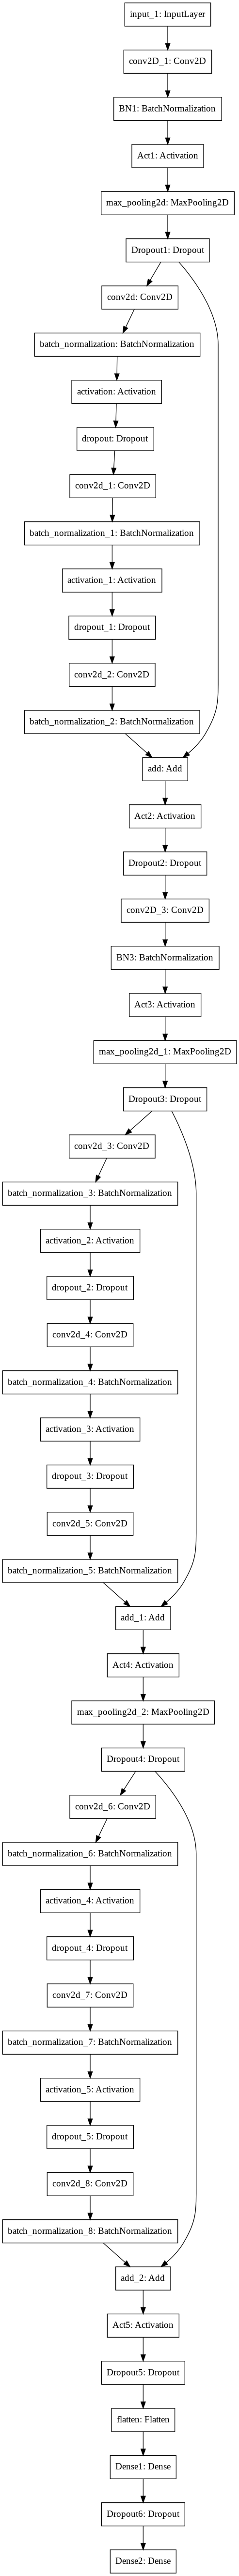

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [52]:
from tensorflow import keras
from tensorflow.keras import layers

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_cnn.h5', save_best_only=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [53]:
history = model.fit(X_train, y_train, batch_size=128,
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
458/458 [==============================] - 53s 43ms/step - loss: 2.2927 - accuracy: 0.1847 - val_loss: 2.2171 - val_accuracy: 0.1916


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/70
458/458 [==============================] - 19s 40ms/step - loss: 2.1014 - accuracy: 0.2345 - val_loss: 2.0109 - val_accuracy: 0.2803
Epoch 3/70
458/458 [==============================] - 18s 40ms/step - loss: 1.8613 - accuracy: 0.3039 - val_loss: 1.3285 - val_accuracy: 0.5056
Epoch 4/70
458/458 [==============================] - 18s 40ms/step - loss: 1.2548 - accuracy: 0.5496 - val_loss: 0.7812 - val_accuracy: 0.7089
Epoch 5/70
458/458 [==============================] - 18s 40ms/step - loss: 0.8762 - accuracy: 0.6968 - val_loss: 0.5531 - val_accuracy: 0.8286
Epoch 6/70
458/458 [==============================] - 19s 41ms/step - loss: 0.6545 - accuracy: 0.7935 - val_loss: 0.4380 - val_accuracy: 0.8698
Epoch 7/70
458/458 [==============================] - 19s 40ms/step - loss: 0.5358 - accuracy: 0.8389 - val_loss: 0.3683 - val_accuracy: 0.8905
Epoch 8/70
458/458 [==============================] - 18s 40ms/step - loss: 0.4607 - accuracy: 0.8640 - val_loss: 0.4203 - val_accuracy:

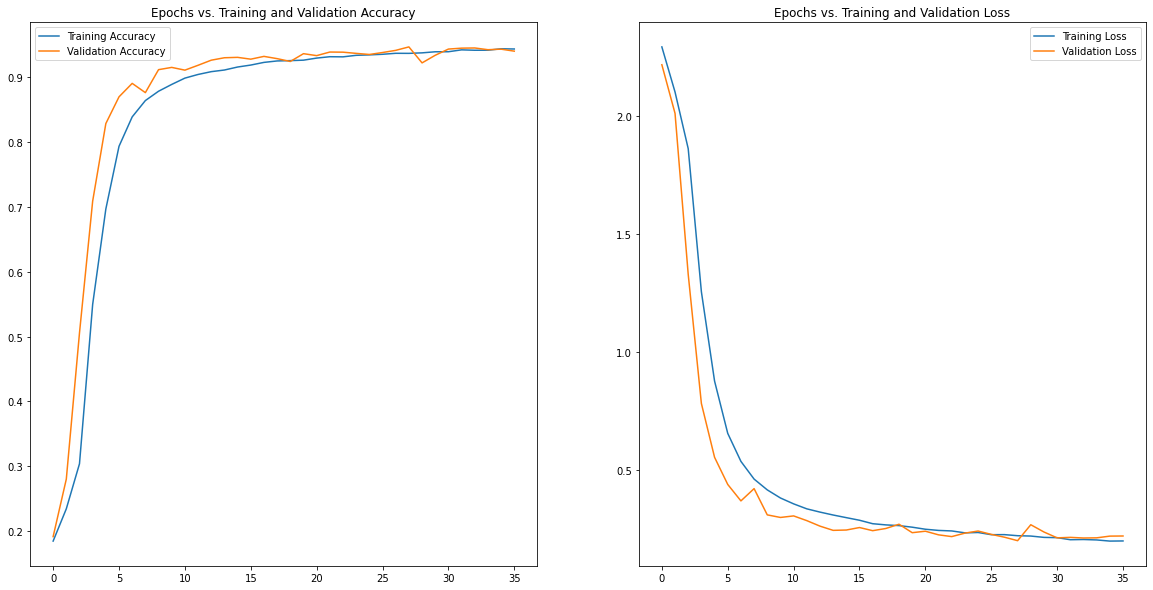

In [54]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [56]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_X, y=test_y, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9479 
Test loss is: 0.1931


# **Visualizations and insights**[2]
The **Confusion Matrix** of the model on the training data, so as to get a sense of how it performs on each class label and how the misclassifications are distributed.\
The **Feature Maps** for a random input image, so as to get a sense of how our model learns the features in each convolutional layer.

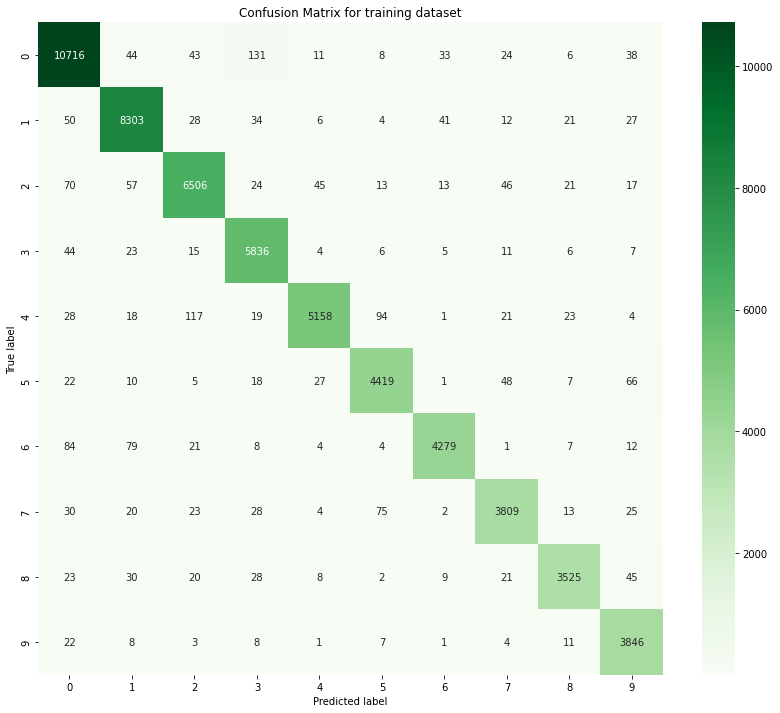

In [57]:
y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

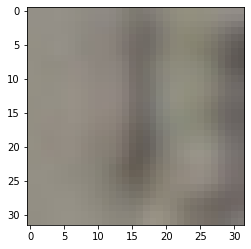

In [58]:
# Get convolutional layers

layers = [model.get_layer('conv2d_1'), 
          model.get_layer('conv2d_2'),
          model.get_layer('conv2d_3'),
          model.get_layer('conv2d_4'),
          model.get_layer('conv2d_5'),
          model.get_layer('conv2d_6')]
# Define a model which gives the outputs of the layers

layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')
img = X_train[42500]
plt.imshow(img)
plt.show()

# **References**



1.   http://ufldl.stanford.edu/housenumbers/
2.   Pre-processing and visualization parts are refered from https://www.kaggle.com/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc
3. Normalization of images: https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258
4. Normalizing any data: https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029
5. Akhter, S.S.M.N., Rege, P.P. Multi-task learning for pre-processing of printed Devanagari document images with hyper-parameter optimization of the deep architecture using Taguchi method. Sādhanā 46, 145 (2021). https://doi.org/10.1007/s12046-021-01664-7
6. Dropout : https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
7. Zagoruyko S, Komodakis N. Paying more attention to attention: Improving the performance of convolutional neural networks via attention transfer. arXiv preprint arXiv:1612.03928. 2016 Dec 12.
8. https://colab.research.google.com/github/zaidalyafeai/AttentioNN/blob/master/Attention_Maps.ipynb#scrollTo=UPDeShtiuYsz
